In [34]:
import pandas as pd
import matplotlib.pyplot as plt
pricing_data = pd.read_csv("Competition_Data.csv")
print(pricing_data.head())

   Index Fiscal_Week_ID   Store_ID   Item_ID   Price  Item_Quantity  \
0      0        2019-11  store_459  item_526  134.49            435   
1      1        2019-11  store_459  item_526  134.49            435   
2      2        2019-11  store_459  item_526  134.49            435   
3      3        2019-11  store_459  item_526  134.49            435   
4      4        2019-11  store_459  item_526  134.49            435   

   Sales_Amount_No_Discount  Sales_Amount  Competition_Price  
0                   4716.74      11272.59             206.44  
1                   4716.74      11272.59             158.01  
2                   4716.74      11272.59             278.03  
3                   4716.74      11272.59             222.66  
4                   4716.74      11272.59             195.32  


In [35]:
pricing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Index                     100000 non-null  int64  
 1   Fiscal_Week_ID            100000 non-null  object 
 2   Store_ID                  100000 non-null  object 
 3   Item_ID                   100000 non-null  object 
 4   Price                     100000 non-null  float64
 5   Item_Quantity             100000 non-null  int64  
 6   Sales_Amount_No_Discount  100000 non-null  float64
 7   Sales_Amount              100000 non-null  float64
 8   Competition_Price         100000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB


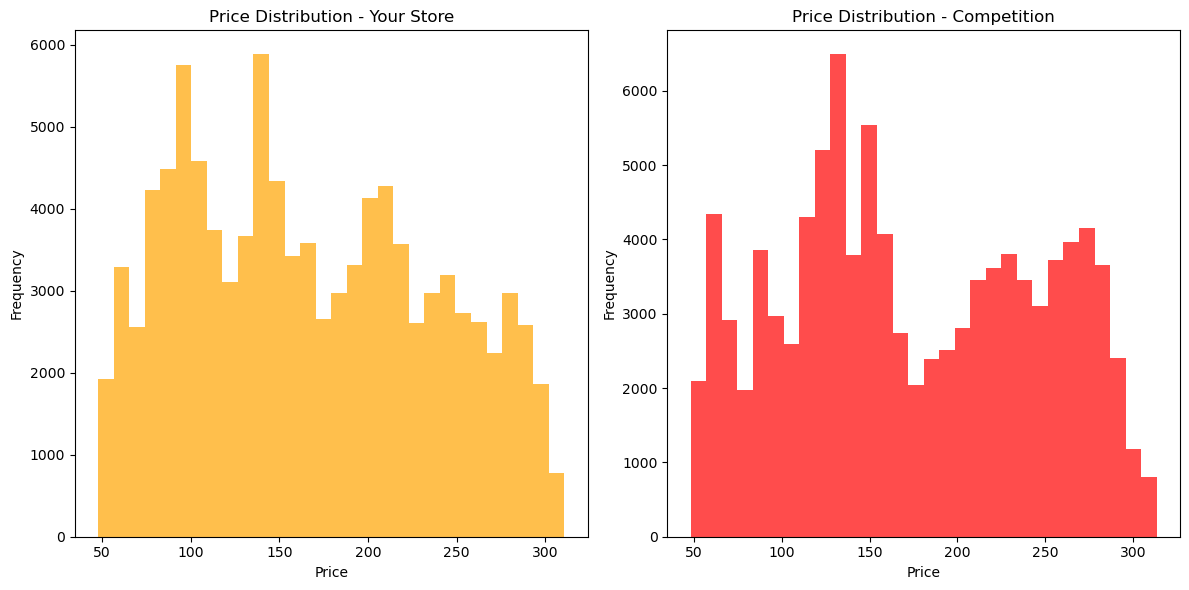

In [36]:
#price distribution of ours VS competition
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(pricing_data['Price'], bins=30,alpha =0.7,color='orange', label='Your Store')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Your Store')
plt.subplot(1,2,2)
plt.hist(pricing_data['Competition_Price'],bins = 30, alpha=0.7, color ='red', label='Competition')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution - Competition')
plt.tight_layout()
plt.show()

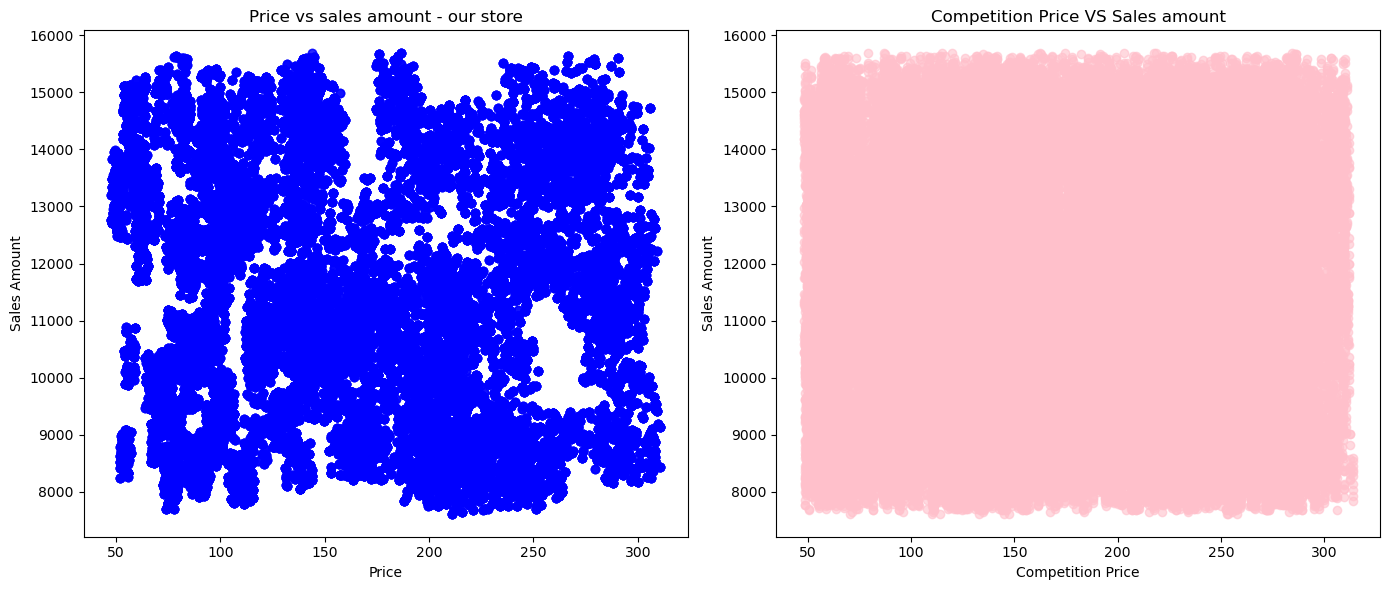

In [37]:
#price VS sales
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(pricing_data['Price'], pricing_data['Sales_Amount'], alpha = 0.6,color= 'blue', label = 'Your Store')
plt.xlabel('Price')
plt.ylabel('Sales Amount')
plt.title('Price vs sales amount - our store')

plt.subplot(1,2,2)
plt.scatter(pricing_data['Competition_Price'], pricing_data['Sales_Amount'], alpha= 0.6, color = 'pink', label = 'Competition')
plt.xlabel('Competition Price')
plt.ylabel('Sales Amount')
plt.title('Competition Price VS Sales amount')
plt.tight_layout()
plt.show()

In [38]:
print(pricing_data['Fiscal_Week_ID'].dtype)

object


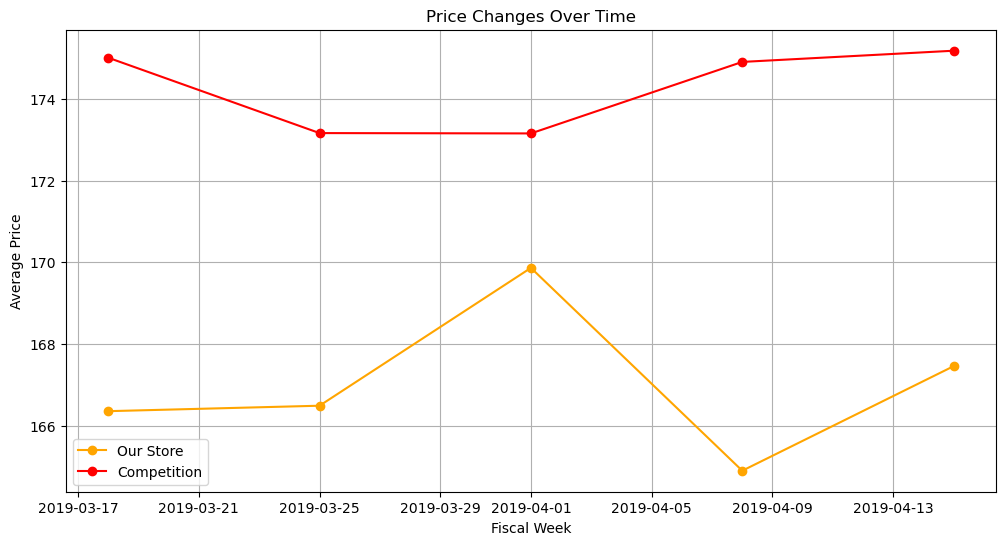

In [39]:


pricing_data['Fiscal_Week_ID'] = pd.to_datetime(pricing_data['Fiscal_Week_ID'] + '-1', format='%Y-%U-%w')
# Calculate weekly average prices
weekly_prices = pricing_data.groupby('Fiscal_Week_ID').agg({
    'Price': 'mean',
    'Competition_Price': 'mean'
}).reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Price'], label='Our Store', marker='o',color ='orange')
plt.plot(weekly_prices['Fiscal_Week_ID'], weekly_prices['Competition_Price'], label='Competition', marker='o', color='red')

plt.xlabel('Fiscal Week')
plt.ylabel('Average Price')
plt.title('Price Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()


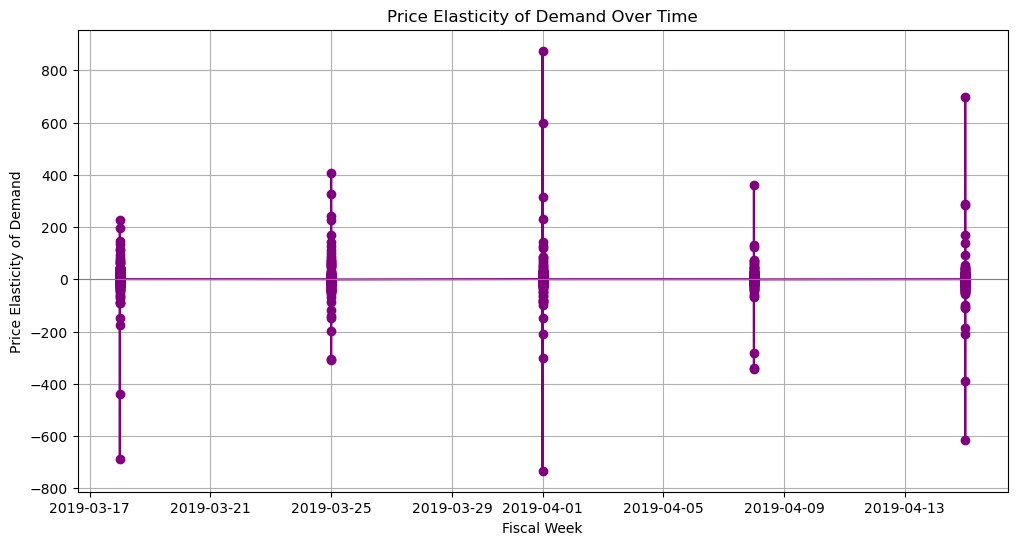

In [40]:
pricing_data['price_change'] = pricing_data['Price'].pct_change()
pricing_data['qty_change'] = pricing_data['Item_Quantity'].pct_change()

pricing_data['elasticity'] = pricing_data['qty_change'] / pricing_data['price_change']

pricing_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
pricing_data.dropna(subset=['elasticity'], inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(pricing_data['Fiscal_Week_ID'], pricing_data['elasticity'], marker='o', linestyle='-', color='purple')
plt.axhline(0, color='grey', linewidth=0.8)
plt.xlabel('Fiscal Week')
plt.ylabel('Price Elasticity of Demand')
plt.title('Price Elasticity of Demand Over Time')
plt.grid(True)
plt.show()

In [41]:
total_sales_your_store = pricing_data['Sales_Amount'].sum()
total_sales_competition = (pricing_data['Competition_Price'] * pricing_data['Item_Quantity']).sum()

total_qty_your_store = pricing_data['Item_Quantity'].sum()
total_qty_competition = pricing_data['Item_Quantity'].sum()  # assuming quantities sold are the same for comparison

summary = pd.DataFrame({
    'Metric': ['Total Sales Amount', 'Total Quantity Sold'],
    'Your Store': [total_sales_your_store, total_qty_your_store],
    'Competition': [total_sales_competition, total_qty_competition]
})


summary

,Metric,Your Store,Competition
0,Total Sales Amount,1.141005e+08,6.962097e+08
1,Total Quantity Sold,3.984776e+06,3.984776e+06


In [42]:


# Define price brackets
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500']

# Create price brackets for both your store and competition
pricing_data['price_bracket'] = pd.cut(pricing_data['Price'], bins=bins, labels=labels, right=False)
pricing_data['competition_price_bracket'] = pd.cut(pricing_data['Competition_Price'], bins=bins, labels=labels, right=False)

# Calculate sales amount by price bracket for your store
sales_by_bracket_your_store = pricing_data.groupby('price_bracket', observed=True)['Sales_Amount'].sum().reset_index()
sales_by_bracket_your_store.columns = ['Price Bracket', 'Your Store Sales Amount']

# Calculate sales amount by price bracket for competition
pricing_data['competition_sales_amt'] = pricing_data['Competition_Price'] * pricing_data['Item_Quantity']
sales_by_bracket_competition = pricing_data.groupby('competition_price_bracket', observed=True)['competition_sales_amt'].sum().reset_index()
sales_by_bracket_competition.columns = ['Price Bracket', 'Competition Sales Amount']

# Merge sales amounts by price bracket
sales_by_bracket = pd.merge(sales_by_bracket_your_store, sales_by_bracket_competition, on='Price Bracket')

# Display the result
print(sales_by_bracket)



  Price Bracket  Your Store Sales Amount  Competition Sales Amount
0          0-50                346800.63              9.305357e+05
1        51-100              24636244.30              4.889277e+07
2       101-150              29645669.06              1.278404e+08
3       151-200              20658418.18              1.092184e+08
4       201-250              20742288.10              1.909748e+08
5       251-300              16778087.66              2.047670e+08
6       301-350               1292959.36              1.358583e+07
